# Baseline Model

Below we have the baseline model using an SVM network.

In [2]:
"""
Baseline Model - SVM
"""

import cv2
import numpy as np
import os

from sklearn import linear_model, metrics, svm 
from sklearn.model_selection import train_test_split

np.random.seed(0)
RANDOM_NUM = np.random.randint(1000)

In [3]:
DATA_PATH = "KLARR_NET_data/fer_2013"

IMG_WIDTH = 48
IMG_HEIGHT = 48

def create_dataset(img_folder):
    """ Creates a dataset of the images in the given folder and returns the
    data and labels array.
    """
    img_data_array = []
    class_name = []
   
    for class_num, dir in enumerate(os.listdir(img_folder)):
        print(f"Class Num: {class_num}, Directory: {dir}")

        for i, filename in enumerate(os.listdir(os.path.join(img_folder, dir))):
            if i % 1000 == 0:
                print(i)

            # Read the image in grayscale
            image_path = os.path.join(img_folder, dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(
                image,
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_AREA
            )

            # Convert to numpy and normalize between 0 and 1
            image = np.array(image).astype('float32').flatten() / 255

            img_data_array.append(image)
            class_name.append(class_num)

    return np.array(img_data_array), np.array(class_name)

X_train, y_train = create_dataset(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    train_size=0.7,
    random_state=RANDOM_NUM)

Class Num: 0, Directory: angry
0
1000
2000
3000
4000
Class Num: 1, Directory: fear
0
1000
2000
3000
4000
5000
Class Num: 2, Directory: happy
0
1000
2000
3000
4000
5000
Class Num: 3, Directory: neutral
0
1000
2000
3000
4000
5000
6000
Class Num: 4, Directory: sad
0
1000
2000
3000
4000
5000
6000
Class Num: 5, Directory: surprise
0
1000
2000
3000


In [4]:
CLASSES = ['angry', 'fear', 'happy' ,'neutral' ,'sad' ,'surprise']

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

print(f"Baseline Model Training Set Size: {len(X_train)}")
print_class_distribution_in_dataset(y_train)

print(f"\nBaseline Model Test Set Size: {len(X_test)}")
print_class_distribution_in_dataset(y_test)


Baseline Model Training Set Size: 22405
Class: angry, Number of Classes: 3466
Class: fear, Number of Classes: 3532
Class: happy, Number of Classes: 3984
Class: neutral, Number of Classes: 4364
Class: sad, Number of Classes: 4252
Class: surprise, Number of Classes: 2807

Baseline Model Test Set Size: 9603
Class: angry, Number of Classes: 1451
Class: fear, Number of Classes: 1545
Class: happy, Number of Classes: 1801
Class: neutral, Number of Classes: 1822
Class: sad, Number of Classes: 1810
Class: surprise, Number of Classes: 1174


In [5]:
from joblib import dump, load
from pathlib import Path

MODELS_DIR = "models"

def train_and_test_baseline(model):
    """ Fits model to training data and prints information about its accuracy
    with respect to test data.
    """
    model.fit(X_train, y_train)

    # Test its accuracy on testing data
    y_pred = model.predict(X_test)
    classification_report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    baseline_test_acc = model.score(X_test, y_test)
    print(f"Baseline Model Test Accuracy: {baseline_test_acc}")

    print(f"Classification report for classifier {model}:")
    print(f"\n{classification_report}")

    print(f"\nConfusion matrix:\n\n{confusion_matrix}")

def save_baseline(model, name):
    file_name = f"baseline_model_{name}.joblib"
    model_location = os.path.join(MODELS_DIR, file_name)

    Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)
    dump(model, model_location)

    # To load the model, use this expression
    # clf = load(model_location)

In [6]:
baseline_model_1 = linear_model.SGDClassifier(
    loss='log',
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_1)

Baseline Model Test Accuracy: 0.28157867333125064
Classification report for classifier SGDClassifier(loss='log', n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.27      0.16      0.20      1451
           1       0.21      0.29      0.24      1545
           2       0.46      0.30      0.36      1801
           3       0.33      0.21      0.25      1822
           4       0.32      0.13      0.18      1810
           5       0.25      0.75      0.37      1174

    accuracy                           0.28      9603
   macro avg       0.30      0.31      0.27      9603
weighted avg       0.31      0.28      0.27      9603


Confusion matrix:

[[232 365 164 143 111 436]
 [123 444 102 150 101 625]
 [153 359 540 182 108 459]
 [129 374 170 377 152 620]
 [196 482 148 241 231 512]
 [ 40 129  42  57  26 880]]


In [7]:
baseline_model_2 = linear_model.SGDClassifier(
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_2)

bm2_params = baseline_model_2.get_params()
save_baseline(
    baseline_model_2,
    f"SGDClassifier_randomstate-{bm2_params['random_state']}"
)

Baseline Model Test Accuracy: 0.2869936478183901
Classification report for classifier SGDClassifier(n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.29      0.11      0.16      1451
           1       0.25      0.19      0.21      1545
           2       0.45      0.24      0.32      1801
           3       0.24      0.66      0.35      1822
           4       0.28      0.19      0.23      1810
           5       0.56      0.27      0.36      1174

    accuracy                           0.29      9603
   macro avg       0.35      0.28      0.27      9603
weighted avg       0.34      0.29      0.27      9603


Confusion matrix:

[[ 159  184  152  722  194   40]
 [  90  291   85  786  188  105]
 [  90  155  441  907  182   26]
 [  77  164  116 1210  213   42]
 [  95  230  127  983  343   32]
 [  31  156   55  532   88  312]]


In [8]:
baseline_model_3 = svm.LinearSVC(
    dual=False,
    C=100,
    max_iter=20,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_3)

bm3_params = baseline_model_3.get_params()
save_baseline(
    baseline_model_3,
    f"LinearSVC_dual-{bm3_params['dual']}_C-{bm3_params['C']}_"
    f"iters-{bm3_params['max_iter']}_randomstate-{bm3_params['random_state']}"
)

Baseline Model Test Accuracy: 0.32541913985212956
Classification report for classifier LinearSVC(C=100, dual=False, max_iter=20, random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.19      0.22      1451
           1       0.24      0.18      0.21      1545
           2       0.41      0.46      0.43      1801
           3       0.30      0.35      0.32      1822
           4       0.29      0.29      0.29      1810
           5       0.42      0.49      0.45      1174

    accuracy                           0.33      9603
   macro avg       0.32      0.33      0.32      9603
weighted avg       0.32      0.33      0.32      9603


Confusion matrix:

[[279 174 276 294 297 131]
 [187 277 223 306 288 264]
 [165 144 832 298 253 109]
 [174 198 288 642 352 168]
 [217 230 294 420 525 124]
 [ 79 111 141 169 104 570]]


In [9]:
baseline_model_4 = linear_model.SGDClassifier(
    n_jobs=-1,
    learning_rate='invscaling',
    eta0=0.005,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_4)

bm4_params = baseline_model_4.get_params()
save_baseline(
    baseline_model_4,
    f"SGDClassifier_lr-{bm4_params['learning_rate']}_eta0-{bm4_params['eta0']}_"
    f"randomstate-{bm4_params['random_state']}"
)

Baseline Model Test Accuracy: 0.3498906591690097
Classification report for classifier SGDClassifier(eta0=0.005, learning_rate='invscaling', n_jobs=-1,
              random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.24      0.25      1451
           1       0.28      0.10      0.15      1545
           2       0.40      0.59      0.48      1801
           3       0.32      0.50      0.39      1822
           4       0.33      0.24      0.27      1810
           5       0.52      0.40      0.45      1174

    accuracy                           0.35      9603
   macro avg       0.35      0.34      0.33      9603
weighted avg       0.35      0.35      0.33      9603


Confusion matrix:

[[ 346   72  368  381  202   82]
 [ 274  159  308  448  207  149]
 [ 177   62 1054  316  147   45]
 [ 176   82  356  910  231   67]
 [ 280   97  353  566  426   88]
 [ 116   90  168  255   80  465]]


# CNN Implementation

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch

from torchvision import datasets, transforms

np.random.seed(0)
torch.manual_seed(1000)
RANDOM_NUM = np.random.randint(1000)

In [11]:
CLASSES = None

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

In [12]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

DATA_PATH = "KLARR_NET_data/fer_2013"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    ])

total_data = datasets.ImageFolder(root=DATA_PATH, transform=TRANSFORM_IMG)
total_data_len = len(total_data)
CLASSES = total_data.classes

print('Number of Images : ', total_data_len)
print_class_distribution_in_dataset(total_data.targets)

Number of Images :  32008
Class: angry, Number of Classes: 4917
Class: fear, Number of Classes: 5077
Class: happy, Number of Classes: 5785
Class: neutral, Number of Classes: 6186
Class: sad, Number of Classes: 6062
Class: surprise, Number of Classes: 3981


In [13]:
train_data_len = int(total_data_len * 0.7)
valid_data_len = int(total_data_len * 0.15)
test_data_len = total_data_len - train_data_len - valid_data_len

train_data, valid_data, test_data = torch.utils.data.random_split(
    total_data,
    (train_data_len, valid_data_len, test_data_len)
)

print(f"Number of Training Images: {len(train_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in train_data])

print(f"\nNumber of Validation Images: {len(valid_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in valid_data])

print(f"\nNumber of Test Images: {len(test_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in test_data])


Number of Training Images: 22405
Class: angry, Number of Classes: 3441
Class: fear, Number of Classes: 3571
Class: happy, Number of Classes: 4096
Class: neutral, Number of Classes: 4284
Class: sad, Number of Classes: 4294
Class: surprise, Number of Classes: 2719

Number of Validation Images: 4801
Class: angry, Number of Classes: 734
Class: fear, Number of Classes: 755
Class: happy, Number of Classes: 867
Class: neutral, Number of Classes: 919
Class: sad, Number of Classes: 896
Class: surprise, Number of Classes: 630

Number of Test Images: 4802
Class: angry, Number of Classes: 742
Class: fear, Number of Classes: 751
Class: happy, Number of Classes: 822
Class: neutral, Number of Classes: 983
Class: sad, Number of Classes: 872
Class: surprise, Number of Classes: 632


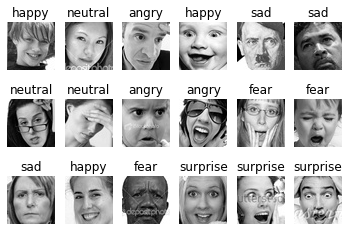

In [82]:
i = 0
printed_imgs = {i: 0 for i in range(6)}

for img, label in torch.utils.data.DataLoader(train_data, batch_size=1):
    class_num = label[0].item()

    if i == 18:
        break
    if printed_imgs[class_num] == 3:
        continue

    printed_imgs[class_num] += 1
    i += 1

    plt.subplot(3, 6, i)
    plt.axis('off')
    plt.title(CLASSES[class_num])
    plt.imshow(img.squeeze(), cmap='gray')

In [14]:
import itertools

from datetime import datetime
from sklearn.metrics import confusion_matrix

USE_CUDA = torch.cuda.is_available()

def get_model_name(name, batch_size, learning_rate, iteration):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_iter{3}_date{4}".format(
      name,
      batch_size,
      learning_rate,
      iteration,
      datetime.now().strftime("%d_%m_%Y-%H_%M")
    )
    return path

def get_accuracy(model, data_loader, dropout=False):
    if(dropout):
        model.eval()
    correct, total = 0, 0

    for imgs, labels in data_loader:
      if USE_CUDA:
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = model(imgs)
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    if(dropout):
        model.train()
    return correct / total

def plot_confusion_matrix(
    model,
    data,
    title="Confusion Matrix",
    normalize=True,
    cmap=plt.cm.Blues
):
    classes = data.dataset.classes

    # Find true and predicted values for the given data
    y_pred = [None] * len(data)
    y_true = [None] * len(data)

    for i, index in enumerate(data.indices):
        X = data.dataset[index][0].unsqueeze(0)

        if USE_CUDA:
            X = X.cuda()

        y_pred[i] = classes[model(X).max(1, keepdim=True)[1].item()]
        y_true[i] = classes[data.dataset[index][1]]

    # Find confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot colourful confusion matrix
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

def train(
    model,
    train_data,
    val_data,
    batch_size=512,
    learning_rate=0.001,
    iterations=10,
    decay=0,
    dropout=False,
    save=True
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    train_loss, train_acc, val_acc = [], [], []

    train_loader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    for iteration in range(iterations):
        iter_loss = float(0)
        for imgs, labels in train_loader:
            if USE_CUDA:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_loss += float(loss.item())

        # Compute training/validation accuracy/loss
        train_loss.append(iter_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader, dropout=dropout))
        val_acc.append(get_accuracy(model, val_loader, dropout=dropout))

        # Save model progress
        if save:
            model_path = get_model_name(model.name, batch_size, learning_rate, iteration)
            torch.save(model.eval().state_dict(), f"models/{model_path}")

        print(("Iteration {}: Train loss: {}, Train accuracy: {}"
              " | Validation accuracy: {}").format(
                iteration + 1,
                train_loss[-1],
                train_acc[-1],
                val_acc[-1]
        ))

    # Plot model training information
    plt.title("Loss Curves")
    plt.plot(range(1, iterations+1), train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1, iterations+1), train_acc, label="Train")
    plt.plot(range(1, iterations+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    plot_confusion_matrix(model, valid_data, title="Model Confusion Matrix (Validation)")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET(nn.Module):
    def __init__(self):
        super(KLARR_NET, self).__init__()
        self.name = 'KLARR_NET'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(9*9*10, 72)
        self.fc2 = nn.Linear(72, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Linear layers
        x = x.view(-1, 9*9*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Iteration 1: Train loss: 1.7649000666358254, Train accuracy: 0.24972104440972998 | Validation accuracy: 0.23849198083732556
Iteration 2: Train loss: 1.6989953246983616, Train accuracy: 0.3208658781521982 | Validation accuracy: 0.3113934596958967
Iteration 3: Train loss: 1.628141928802837, Train accuracy: 0.3607230528899799 | Validation accuracy: 0.34076234117892107
Iteration 4: Train loss: 1.5879188477993011, Train accuracy: 0.367284088373131 | Validation accuracy: 0.35367631743386796
Iteration 5: Train loss: 1.56315755573186, Train accuracy: 0.38879714349475564 | Validation accuracy: 0.3734638616954801
Iteration 6: Train loss: 1.5359372306953778, Train accuracy: 0.4003124302611024 | Validation accuracy: 0.378671110185378
Iteration 7: Train loss: 1.5163667635484175, Train accuracy: 0.40901584467752733 | Validation accuracy: 0.39408456571547595
Iteration 8: Train loss: 1.4946831898255781, Train accuracy: 0.413523767016291 | Validation accuracy: 0.3899187669235576
Iteration 9: Train loss

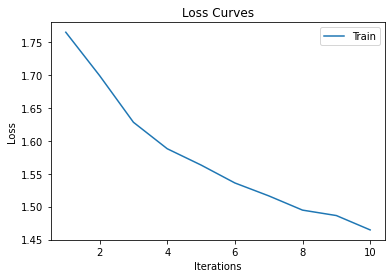

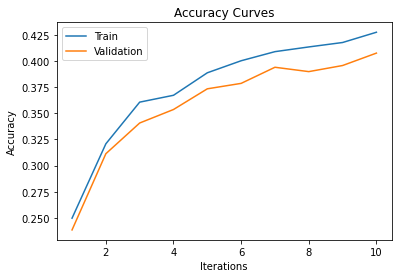

Final Training Accuracy: 0.4275831287659005
Final Validation Accuracy: 0.4076234117892106


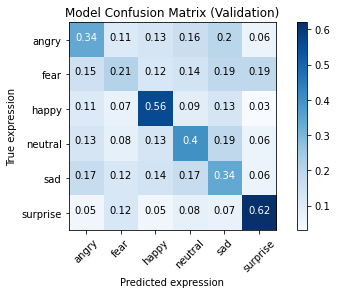

In [16]:
model1 = KLARR_NET()

if USE_CUDA:
    model1 = model1.cuda()

train(model1, train_data, valid_data, save=False)

Iteration 1: Train loss: 1.695013057779182, Train accuracy: 0.35076991742914526 | Validation accuracy: 0.33805457196417416
Iteration 2: Train loss: 1.5466219755736264, Train accuracy: 0.40209774603883064 | Validation accuracy: 0.3932514059570923
Iteration 3: Train loss: 1.4679437320340762, Train accuracy: 0.43597411292122296 | Validation accuracy: 0.40533222245365547
Iteration 4: Train loss: 1.4199401140213013, Train accuracy: 0.44467752733764787 | Validation accuracy: 0.4028327431785045
Iteration 5: Train loss: 1.3804115510799668, Train accuracy: 0.47043070743137694 | Validation accuracy: 0.41220579046032074
Iteration 6: Train loss: 1.3390437730334022, Train accuracy: 0.4827940191921446 | Validation accuracy: 0.4149135596750677
Iteration 7: Train loss: 1.302126430991021, Train accuracy: 0.5231421557688016 | Validation accuracy: 0.43824203290981045
Iteration 8: Train loss: 1.2637527713721448, Train accuracy: 0.5121624637357732 | Validation accuracy: 0.4219954176213289
Iteration 9: Trai

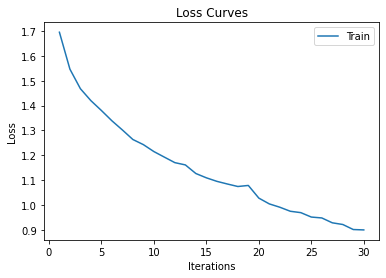

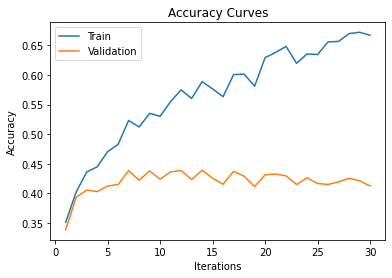

Final Training Accuracy: 0.6673064048203526
Final Validation Accuracy: 0.41241408039991667


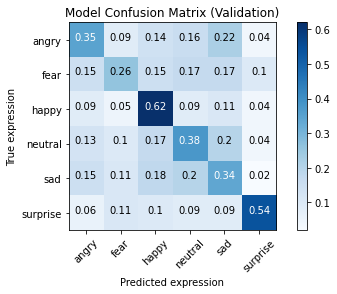

In [17]:
model2 = KLARR_NET()

if USE_CUDA:
    model2 = model2.cuda()

train(
    model2,
    train_data,
    valid_data,
    learning_rate=0.005, 
    batch_size=128,
    iterations=30
)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET2(nn.Module):
    def __init__(self):
        super(KLARR_NET2, self).__init__()
        self.name = 'KLARR_NET2'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 15, 5)
        self.conv2 = nn.Conv2d(15, 30, 3)
        self.conv3 = nn.Conv2d(30, 45, 2)

        self.fc1 = nn.Linear(4*4*45, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1, 4*4*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.721878869967027, Train accuracy: 0.3076545413970096 | Validation accuracy: 0.30139554259529266
Iteration 2: Train loss: 1.6221396638588472, Train accuracy: 0.3604552555233207 | Validation accuracy: 0.3474276192459904
Iteration 3: Train loss: 1.5561688610098579, Train accuracy: 0.39714349475563493 | Validation accuracy: 0.38596125807123516
Iteration 4: Train loss: 1.503399227153171, Train accuracy: 0.41405936174960944 | Validation accuracy: 0.40220787335971675
Iteration 5: Train loss: 1.471812129020691, Train accuracy: 0.42173621959384067 | Validation accuracy: 0.4072068319100187
Iteration 6: Train loss: 1.4452149759639392, Train accuracy: 0.4307074313769248 | Validation accuracy: 0.40866486148719017
Iteration 7: Train loss: 1.415590526028113, Train accuracy: 0.4471323365320241 | Validation accuracy: 0.4222037075609248
Iteration 8: Train loss: 1.3961498330939899, Train accuracy: 0.4374916313322919 | Validation accuracy: 0.40533222245365547
Iteration 9: Train l

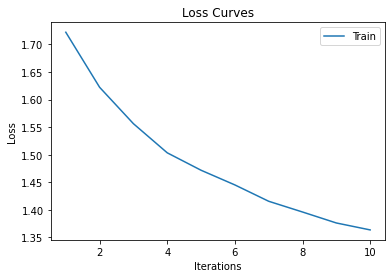

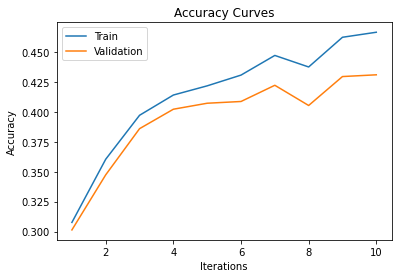

Final Training Accuracy: 0.4665030127203749
Final Validation Accuracy: 0.4309518850239533


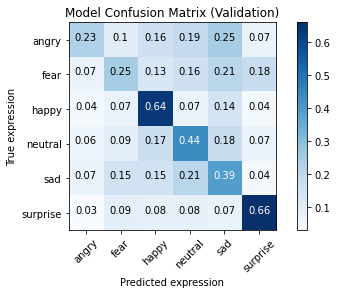

In [19]:
model3 = KLARR_NET()

if USE_CUDA:
    model3 = model3.cuda()

train(
    model3,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7386970750310204, Train accuracy: 0.28997991519750055 | Validation accuracy: 0.28556550718600293
Iteration 2: Train loss: 1.5887453258037567, Train accuracy: 0.37554117384512387 | Validation accuracy: 0.3578421162257863
Iteration 3: Train loss: 1.4876535778695887, Train accuracy: 0.427047534032582 | Validation accuracy: 0.3982503645073943
Iteration 4: Train loss: 1.412579826333306, Train accuracy: 0.46114706538719036 | Validation accuracy: 0.4257446365340554
Iteration 5: Train loss: 1.3535246402025223, Train accuracy: 0.4831510823476903 | Validation accuracy: 0.4428244115809206
Iteration 6: Train loss: 1.3052525371313095, Train accuracy: 0.5114929703191252 | Validation accuracy: 0.4557383878358675
Iteration 7: Train loss: 1.259594435041601, Train accuracy: 0.5201071189466637 | Validation accuracy: 0.46781920433243074
Iteration 8: Train loss: 1.213216238401153, Train accuracy: 0.5466636911403705 | Validation accuracy: 0.4805248906477817
Iteration 9: Train loss

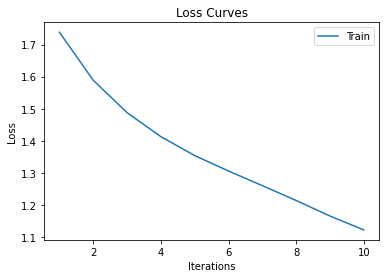

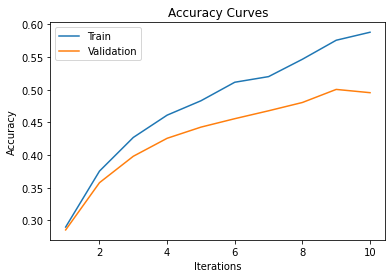

Final Training Accuracy: 0.5879937513947779
Final Validation Accuracy: 0.49552176629868777


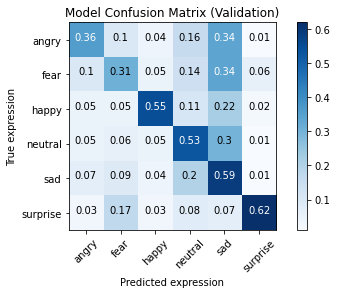

In [20]:
model4 = KLARR_NET2()

if USE_CUDA:
    model4 = model4.cuda()

train(
    model4,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.736262016675689, Train accuracy: 0.2818120955143941 | Validation accuracy: 0.2714017912934805
Iteration 2: Train loss: 1.6242579357190565, Train accuracy: 0.3814773488060701 | Validation accuracy: 0.3647156842324516
Iteration 3: Train loss: 1.5117732056162574, Train accuracy: 0.39964293684445434 | Validation accuracy: 0.38950218704436573
Iteration 4: Train loss: 1.4453464367172935, Train accuracy: 0.44066056683775945 | Validation accuracy: 0.421787127681733
Iteration 5: Train loss: 1.3808430216529153, Train accuracy: 0.46400357063155545 | Validation accuracy: 0.42845240574880233
Iteration 6: Train loss: 1.3305914551019669, Train accuracy: 0.49953135460834636 | Validation accuracy: 0.4505311393459696
Iteration 7: Train loss: 1.2898477342995731, Train accuracy: 0.5180540058022762 | Validation accuracy: 0.45865444699021035
Iteration 8: Train loss: 1.2376354851505973, Train accuracy: 0.5391207319794689 | Validation accuracy: 0.4651114351176838
Iteration 9: Train 

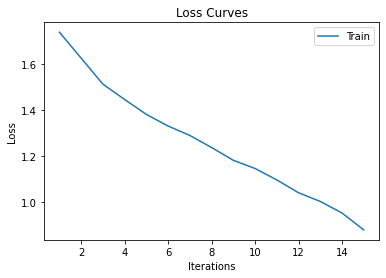

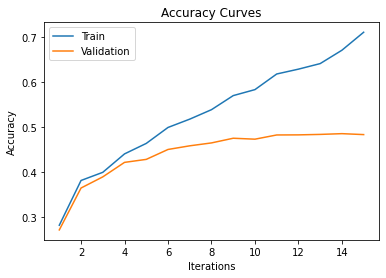

Final Training Accuracy: 0.7115376032135684
Final Validation Accuracy: 0.48364923974172047


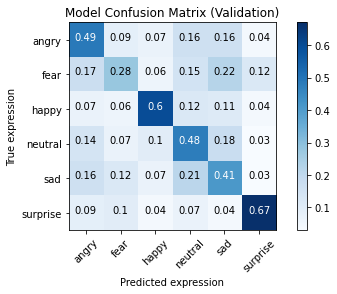

In [21]:
model5 = KLARR_NET2()

if USE_CUDA:
    model5 = model5.cuda()

train(
    model5,
    train_data,
    valid_data,
    learning_rate=0.003,
    batch_size=256,
    iterations=15
)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET3(nn.Module):
    def __init__(self):
        super(KLARR_NET3, self).__init__()
        self.name = 'KLARR_NET3'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        self.fc1 = nn.Linear(8*8*90, 125)
        self.fc2 = nn.Linear(125, 50)
        self.fc3 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.730642088434913, Train accuracy: 0.31135907163579557 | Validation accuracy: 0.29660487398458657
Iteration 2: Train loss: 1.5815390321341427, Train accuracy: 0.38759205534478913 | Validation accuracy: 0.3742970214538638
Iteration 3: Train loss: 1.471369433132085, Train accuracy: 0.44177638919883955 | Validation accuracy: 0.41241408039991667
Iteration 4: Train loss: 1.3827291754159061, Train accuracy: 0.4566837759428699 | Validation accuracy: 0.42491147677567176
Iteration 5: Train loss: 1.3037321987477215, Train accuracy: 0.4952912296362419 | Validation accuracy: 0.4499062695271818
Iteration 6: Train loss: 1.242600535804575, Train accuracy: 0.5388529346128096 | Validation accuracy: 0.4742761924599042
Iteration 7: Train loss: 1.1798745813694866, Train accuracy: 0.5816112474893997 | Validation accuracy: 0.4984378254530306
Iteration 8: Train loss: 1.107258295471018, Train accuracy: 0.5795581343450122 | Validation accuracy: 0.48198292022495315
Iteration 9: Train lo

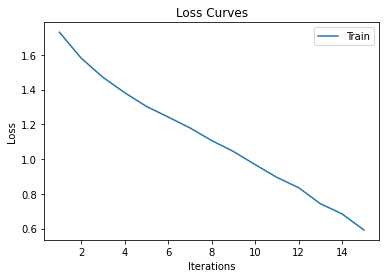

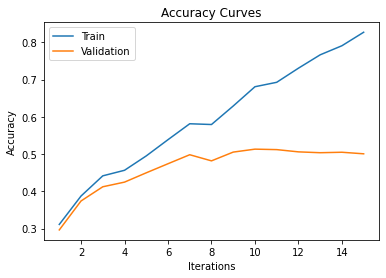

Final Training Accuracy: 0.8272706985047981
Final Validation Accuracy: 0.5009373047281817


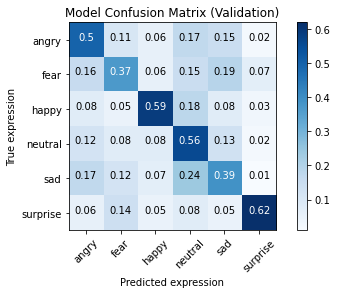

In [23]:
model6 = KLARR_NET3()

if USE_CUDA:
    model6 = model6.cuda()

train(
    model6,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET4(nn.Module):
    def __init__(self):
        super(KLARR_NET4, self).__init__()
        self.name = 'KLARR_NET4'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 49x49 (30ch)
        49x49 (30ch) --> maxpool --> 24x24 (30ch)
        24x24 (30ch) --> conv2 --> 26x26 (60ch)
        26x26 (60ch) --> maxpool --> 13x13 (60ch)
        13x13 (60ch) --> conv3 --> 16x16 (90ch)
        16x16 (90ch) --> maxpool --> 8x8 (90ch)
        '''

        self.fc1 = nn.Linear(8*8*90, 75)
        self.fc2 = nn.Linear(75, 20)
        self.fc3 = nn.Linear(20, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.734131696549329, Train accuracy: 0.2893550546752957 | Validation accuracy: 0.2830660279108519
Iteration 2: Train loss: 1.6090521148659966, Train accuracy: 0.3835750948449007 | Validation accuracy: 0.35305144761508017
Iteration 3: Train loss: 1.5022875585339286, Train accuracy: 0.41214014728855164 | Validation accuracy: 0.3970006248698188
Iteration 4: Train loss: 1.4299319752238013, Train accuracy: 0.4380718589600536 | Validation accuracy: 0.42137054780254113
Iteration 5: Train loss: 1.367677710273049, Train accuracy: 0.46967194822584246 | Validation accuracy: 0.4384503228494064
Iteration 6: Train loss: 1.3114769025282427, Train accuracy: 0.5047980361526445 | Validation accuracy: 0.4496979795875859
Iteration 7: Train loss: 1.2740881050174886, Train accuracy: 0.5238562820798929 | Validation accuracy: 0.4757342220370756
Iteration 8: Train loss: 1.2332462153651498, Train accuracy: 0.5392546306627984 | Validation accuracy: 0.47156842324515724
Iteration 9: Train lo

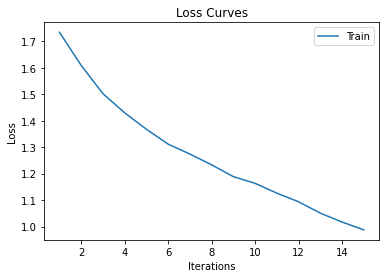

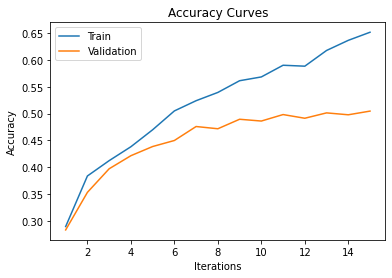

Final Training Accuracy: 0.6514170943985718
Final Validation Accuracy: 0.5044782337013122


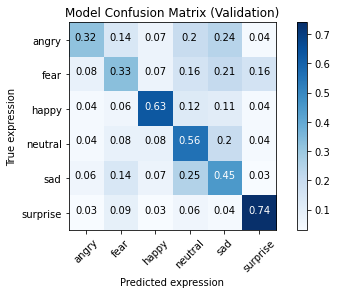

In [25]:
model7 = KLARR_NET4()

if USE_CUDA:
    model7 = model7.cuda()

train(
    model7,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET5(nn.Module):
    def __init__(self):
        super(KLARR_NET5, self).__init__()
        self.name = 'KLARR_NET5'

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_input = 4*4*256

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input, 75),
            nn.ReLU(),

            nn.Linear(75, 20),
            nn.ReLU(),

            nn.Linear(20, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, self.fc_input))
        return x

Iteration 1: Train loss: 1.758304624394937, Train accuracy: 0.24146395893773712 | Validation accuracy: 0.24328264944803166
Iteration 2: Train loss: 1.6650205633857034, Train accuracy: 0.3170274492300826 | Validation accuracy: 0.30451989168923144
Iteration 3: Train loss: 1.5468343130566857, Train accuracy: 0.4098638696719482 | Validation accuracy: 0.39450114559466776
Iteration 4: Train loss: 1.4484094083309174, Train accuracy: 0.44351707208212454 | Validation accuracy: 0.4211622578629452
Iteration 5: Train loss: 1.379462637684562, Train accuracy: 0.4652532916759652 | Validation accuracy: 0.44574047073526346
Iteration 6: Train loss: 1.3224501636895267, Train accuracy: 0.49015844677527337 | Validation accuracy: 0.45240574880233286
Iteration 7: Train loss: 1.2680103873664683, Train accuracy: 0.5198839544744477 | Validation accuracy: 0.4790668610706103
Iteration 8: Train loss: 1.231976636431434, Train accuracy: 0.5426020977460388 | Validation accuracy: 0.48135805040616536
Iteration 9: Train

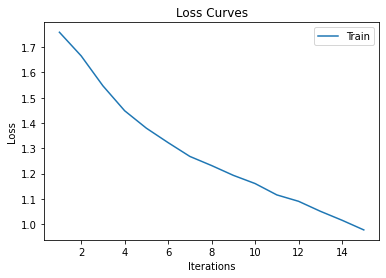

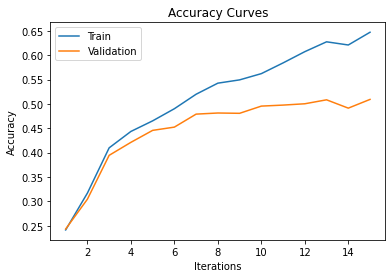

Final Training Accuracy: 0.647087703637581
Final Validation Accuracy: 0.5092689023120184


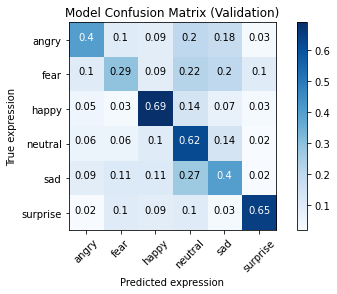

In [27]:
model8 = KLARR_NET5()

if USE_CUDA:
    model8 = model8.cuda()

train(
    model8,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [28]:
'''
The above models had a peak Validation Accuracy of 0.535 (KLARR_NET3, model 6, iter 13).
The previous 3 KLARR_NET architectures used a combination of 3 convolutional layers and 3 linear layers.
The following models will modify the original architecture by using research and proven successful tuning strategies.
'''

'\nThe above models had a peak Validation Accuracy of 0.535 (KLARR_NET3, model 6, iter 13).\nThe previous 3 KLARR_NET architectures used a combination of 3 convolutional layers and 3 linear layers.\nThe following models will modify the original architecture by using research and proven successful tuning strategies.\n'

In [29]:
'''
Try increasing number of convolutional layers, with depth increasing with time.
Idea is that model will learn deeper features, while width of each layer is small (3x3).
Keep kernels 3x3 but increase output channels
Have 5 convolutional and 2 linear layers
'''

class KLARR_NET6(nn.Module):
    def __init__(self):
        super(KLARR_NET6, self).__init__()
        self.name = 'KLARR_NET6'

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 150, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (150ch)
        6x6 (150ch) --> avgpool --> 3x3 (150ch)
        '''

        self.fc1 = nn.Linear(3*3*150, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.avgpool(F.relu(self.conv5(x)))

        # Linear layers
        x = x.view(-1,3*3*150)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7716571512547405, Train accuracy: 0.21379156438295024 | Validation accuracy: 0.21224744844823995
Iteration 2: Train loss: 1.7473174076188693, Train accuracy: 0.23427806293238115 | Validation accuracy: 0.23870027077692146
Iteration 3: Train loss: 1.7385817644270984, Train accuracy: 0.2488730194153091 | Validation accuracy: 0.24911476775671734
Iteration 4: Train loss: 1.6945427358150482, Train accuracy: 0.31028788216915865 | Validation accuracy: 0.29639658404499064
Iteration 5: Train loss: 1.593072697520256, Train accuracy: 0.36478464628431156 | Validation accuracy: 0.3482607790043741
Iteration 6: Train loss: 1.5176292725584724, Train accuracy: 0.40428475786654766 | Validation accuracy: 0.3901270568631535
Iteration 7: Train loss: 1.4737105112184177, Train accuracy: 0.42267351037714795 | Validation accuracy: 0.39679233493022287
Iteration 8: Train loss: 1.4159003536809573, Train accuracy: 0.42624414193260435 | Validation accuracy: 0.4038741928764841
Iteration 9: 

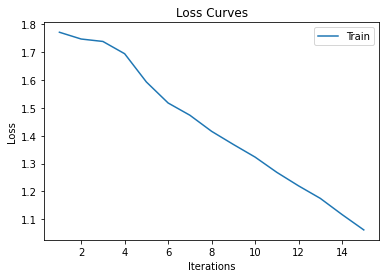

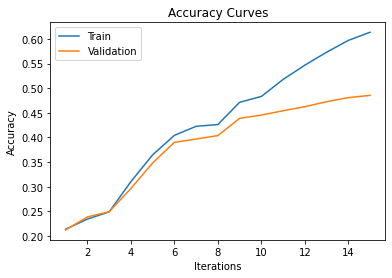

Final Training Accuracy: 0.613746931488507
Final Validation Accuracy: 0.4855238491980837


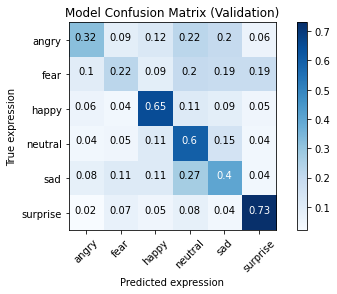

In [30]:
model6a = KLARR_NET6()

if USE_CUDA:
    model6a = model6a.cuda()

train(
    model6a,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

Iteration 1: Train loss: 1.7717210352420807, Train accuracy: 0.22396786431600088 | Validation accuracy: 0.2176629868777338
Iteration 2: Train loss: 1.7461873265829952, Train accuracy: 0.25186342334300377 | Validation accuracy: 0.2436992293272235
Iteration 3: Train loss: 1.7108397294174542, Train accuracy: 0.2876590046864539 | Validation accuracy: 0.2841074776088315
Iteration 4: Train loss: 1.6181241436438127, Train accuracy: 0.3601874581566615 | Validation accuracy: 0.3376379920849823
Iteration 5: Train loss: 1.5400310036810962, Train accuracy: 0.3866547645614818 | Validation accuracy: 0.35617579670901894
Iteration 6: Train loss: 1.4857325553894043, Train accuracy: 0.4171836643606338 | Validation accuracy: 0.3909602166215372
Iteration 7: Train loss: 1.441636472940445, Train accuracy: 0.43293907609908505 | Validation accuracy: 0.39387627577588
Iteration 8: Train loss: 1.397926701740785, Train accuracy: 0.43084133006025443 | Validation accuracy: 0.3922099562591127
Iteration 9: Train loss

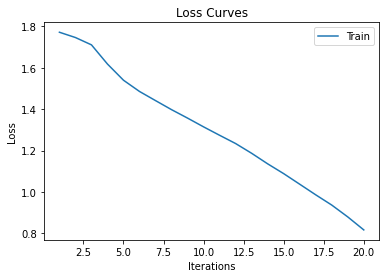

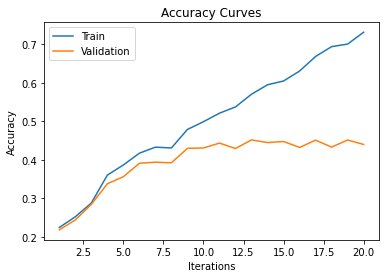

Final Training Accuracy: 0.7318455701852266
Final Validation Accuracy: 0.4399083524265778


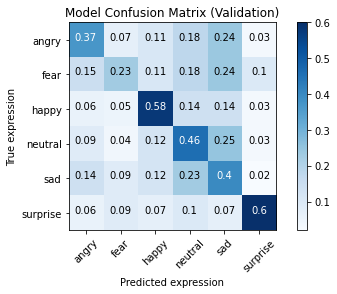

In [31]:
'''
Improvement between epochs, but slow.
Increase learning rate to reach min faster.
Increase number of iterations.
'''

model6b = KLARR_NET6()

if USE_CUDA:
    model6b = model6b.cuda()

train(
    model6b,
    train_data,
    valid_data,
    learning_rate=0.005,
    batch_size=256,
    iterations=20
)

In [32]:
'''
Use batch normalization layers to try to improve accuracy and speed up training.
Increase number of channels in final output layer.
Decrease learning rate to 0.001.

Could later use weight decay or dropout layers if we notice overfitting.
'''

class KLARR_NET7(nn.Module):
    def __init__(self):
        super(KLARR_NET7, self).__init__()
        self.name = 'KLARR_NET7'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7416258427229794, Train accuracy: 0.29381834411961616 | Validation accuracy: 0.28931472609872944
Iteration 2: Train loss: 1.6458386480808258, Train accuracy: 0.3665253291675965 | Validation accuracy: 0.34659445948760675
Iteration 3: Train loss: 1.5233895182609558, Train accuracy: 0.42048649854943093 | Validation accuracy: 0.3995001041449698
Iteration 4: Train loss: 1.4079893068833784, Train accuracy: 0.461727293014952 | Validation accuracy: 0.4386586127890023
Iteration 5: Train loss: 1.3172445378520272, Train accuracy: 0.5165811202856505 | Validation accuracy: 0.469693813788794
Iteration 6: Train loss: 1.2360008467327466, Train accuracy: 0.5479580450792234 | Validation accuracy: 0.48198292022495315
Iteration 7: Train loss: 1.1616419702768326, Train accuracy: 0.5684445436286543 | Validation accuracy: 0.49177254738596127
Iteration 8: Train loss: 1.091432398693128, Train accuracy: 0.6113813880830172 | Validation accuracy: 0.5023953343053531
Iteration 9: Train lo

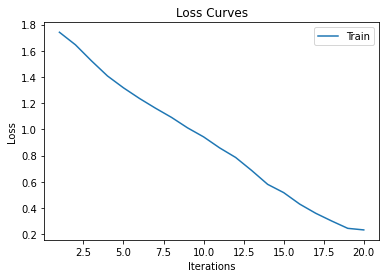

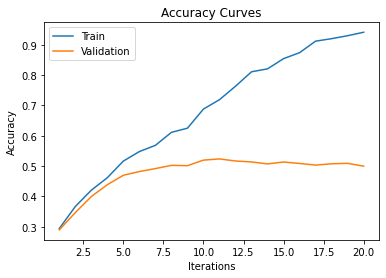

Final Training Accuracy: 0.9417540727516179
Final Validation Accuracy: 0.49968756509060613


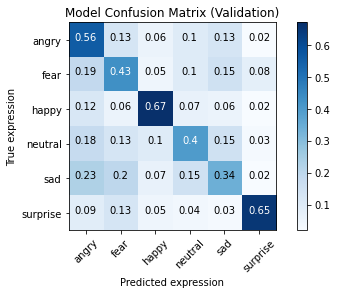

'\nThis model clearly underfits and does not improve after 8 iterations\n'

In [33]:
model7a = KLARR_NET7()

if USE_CUDA:
    model7a = model7a.cuda()

train(
    model7a,
    train_data,
    valid_data,
    learning_rate=0.001,
    batch_size=256,
    iterations=20
)

'''
This model clearly underfits and does not improve after 8 iterations
'''

Iteration 1: Train loss: 1.760992256077853, Train accuracy: 0.24003570631555457 | Validation accuracy: 0.24224119975005207
Iteration 2: Train loss: 1.6881271661682562, Train accuracy: 0.31675965186342336 | Validation accuracy: 0.31097687981670485
Iteration 3: Train loss: 1.547108190303499, Train accuracy: 0.41129212229413076 | Validation accuracy: 0.3972089148094147
Iteration 4: Train loss: 1.4156431291591038, Train accuracy: 0.44213345235438517 | Validation accuracy: 0.42491147677567176
Iteration 5: Train loss: 1.321297443725846, Train accuracy: 0.47234992189243474 | Validation accuracy: 0.43657571339304313
Iteration 6: Train loss: 1.2613275945186615, Train accuracy: 0.5209551439410846 | Validation accuracy: 0.462195375963341
Iteration 7: Train loss: 1.1864531487226486, Train accuracy: 0.5316670386074537 | Validation accuracy: 0.4742761924599042
Iteration 8: Train loss: 1.1141203164376996, Train accuracy: 0.6006694934166481 | Validation accuracy: 0.4951051864194959
Iteration 9: Train 

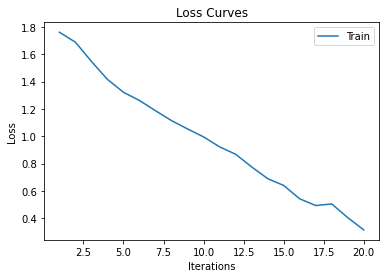

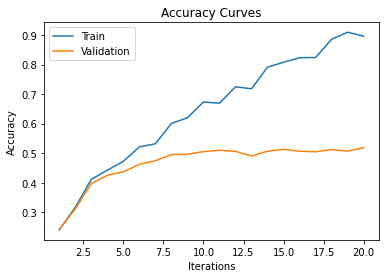

Final Training Accuracy: 0.8960053559473332
Final Validation Accuracy: 0.5184336596542387


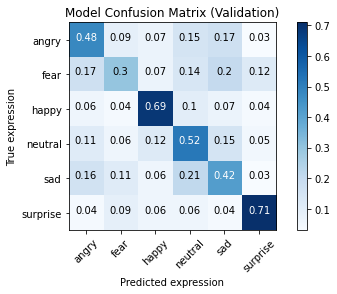

In [34]:
'''
Current best model: @ iteration 16, Validation accuracy: 0.5386377837950427
'''

model7d = KLARR_NET7()

if USE_CUDA:
    model7d = model7d.cuda()

train(
    model7d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    iterations=20
)

In [35]:
'''
Increasing num of conv channels and adding batch normalization worked well
Training accuracy kept improving (up to 90%) but validation accuracy plateaued.

Exeriment with weight decay and dropout layers to try to resolve this overfitting issue.
'''

class KLARR_NET8(nn.Module):
    def __init__(self):
        super(KLARR_NET8, self).__init__()
        self.name = 'KLARR_NET8'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.dropout_50 = nn.Dropout2d()
        self.dropout_25 = nn.Dropout2d(p=0.25)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.dropout_50(x)
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))
        x = self.dropout_25(x)

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.766478680074215, Train accuracy: 0.21169381834411963 | Validation accuracy: 0.2189127265153093
Iteration 2: Train loss: 1.7757985212586143, Train accuracy: 0.21080116045525552 | Validation accuracy: 0.20287440116642366
Iteration 3: Train loss: 1.7623041780157522, Train accuracy: 0.21954920776612363 | Validation accuracy: 0.21703811705894605
Iteration 4: Train loss: 1.7479615319858899, Train accuracy: 0.1674626199509038 | Validation accuracy: 0.17079775046865237
Iteration 5: Train loss: 1.738111142407764, Train accuracy: 0.25360410622628876 | Validation accuracy: 0.2593209747969173
Iteration 6: Train loss: 1.658905922689221, Train accuracy: 0.31908056237446997 | Validation accuracy: 0.30660279108519056
Iteration 7: Train loss: 1.5569032674485987, Train accuracy: 0.37830841330060255 | Validation accuracy: 0.36200791501770463
Iteration 8: Train loss: 1.477835331450809, Train accuracy: 0.39165364873912073 | Validation accuracy: 0.3759633409706311
Iteration 9: Tra

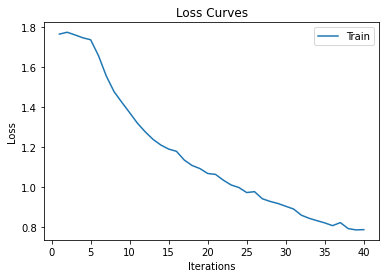

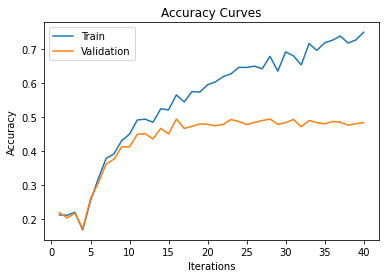

Final Training Accuracy: 0.7505913858513724
Final Validation Accuracy: 0.48406581962091233


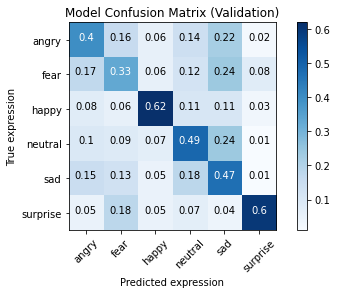

In [36]:
model8c = KLARR_NET8()

if USE_CUDA:
    model8c = model8c.cuda()

train(
    model8c,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.001,
    dropout=True,
    iterations=40
)

Iteration 1: Train loss: 1.770297115499323, Train accuracy: 0.15746485159562598 | Validation accuracy: 0.16121641324724015
Iteration 2: Train loss: 1.7762876749038696, Train accuracy: 0.19464405266681545 | Validation accuracy: 0.1866277858779421
Iteration 3: Train loss: 1.7433393468910998, Train accuracy: 0.25445213122070964 | Validation accuracy: 0.25265569672984795
Iteration 4: Train loss: 1.6864198006012223, Train accuracy: 0.2632001785315778 | Validation accuracy: 0.2653613830451989
Iteration 5: Train loss: 1.6111775433475322, Train accuracy: 0.32247266235215355 | Validation accuracy: 0.31951676734013745
Iteration 6: Train loss: 1.5355204540220173, Train accuracy: 0.3778620843561705 | Validation accuracy: 0.35513434701103935
Iteration 7: Train loss: 1.449780561029911, Train accuracy: 0.36277616603436735 | Validation accuracy: 0.3451364299104353
Iteration 8: Train loss: 1.3946194276213646, Train accuracy: 0.41892434724391875 | Validation accuracy: 0.38866902728598207
Iteration 9: Tr

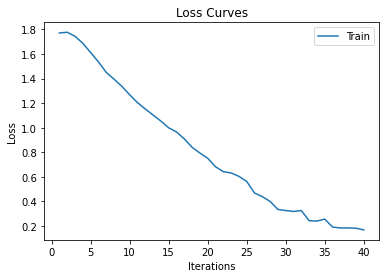

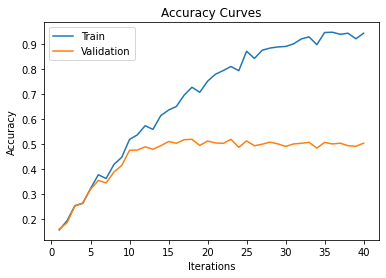

Final Training Accuracy: 0.9431376924793573
Final Validation Accuracy: 0.5040616538221204


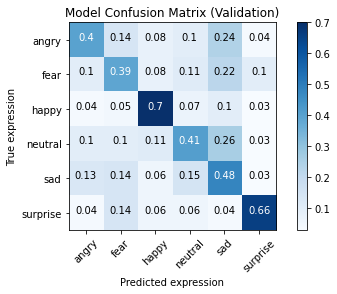

In [37]:
model8d = KLARR_NET8()

if USE_CUDA:
    model8d = model8d.cuda()

train(
    model8d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.0001,
    dropout=True,
    iterations=40
)

In [38]:
'''
Done architecture tuning. Time for hyperparameter tuning.
Tune DECAY, BATCH SIZE, and LR for current best (8? = ? @ iter ?)
'''

'\nDone architecture tuning. Time for hyperparameter tuning.\nTune DECAY, BATCH SIZE, and LR for current best (8? = ? @ iter ?)\n'

In [39]:
'''
Can further implement early stop based on validation loss, and reduce lr as training goes on
Could also perform transfer learning
'''

'\nCan further implement early stop based on validation loss, and reduce lr as training goes on\nCould also perform transfer learning\n'

In [43]:
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)
for param in resnet152.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = resnet152.fc.in_features     # 2048
resnet152.fc = nn.Sequential(
    nn.Linear(num_features, 64),
    nn.Linear(64, 32),
    nn.Linear(32, 2)
)

train(resnet152, train_data, valid_data, learning_rate=0.001, batch_size=128, iterations=10)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[128, 1, 48, 48] to have 3 channels, but got 1 channels instead